<a href="https://colab.research.google.com/github/oktaviacitra/time-series/blob/main/timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

origin_path = '/content/drive'
drive.mount(origin_path)
folder_path = origin_path + '/MyDrive/Learning Journey/AirBnB/'

Mounted at /content/drive


In [2]:
import pandas as pd

dataframe = pd.read_csv(folder_path + 'ABNB.csv')
dataframe['Date'] = pd.to_datetime(dataframe['Date'])
dataframe.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-12-11,146.550003,151.500000,135.100006,139.250000,139.250000,26980800
1,2020-12-14,135.000000,135.300003,125.160004,130.000000,130.000000,16966100
2,2020-12-15,126.690002,127.599998,121.500000,124.800003,124.800003,10914400
3,2020-12-16,125.830002,142.000000,124.910004,137.990005,137.990005,20409600
4,2020-12-17,143.000000,152.449997,142.669998,147.050003,147.050003,15054700


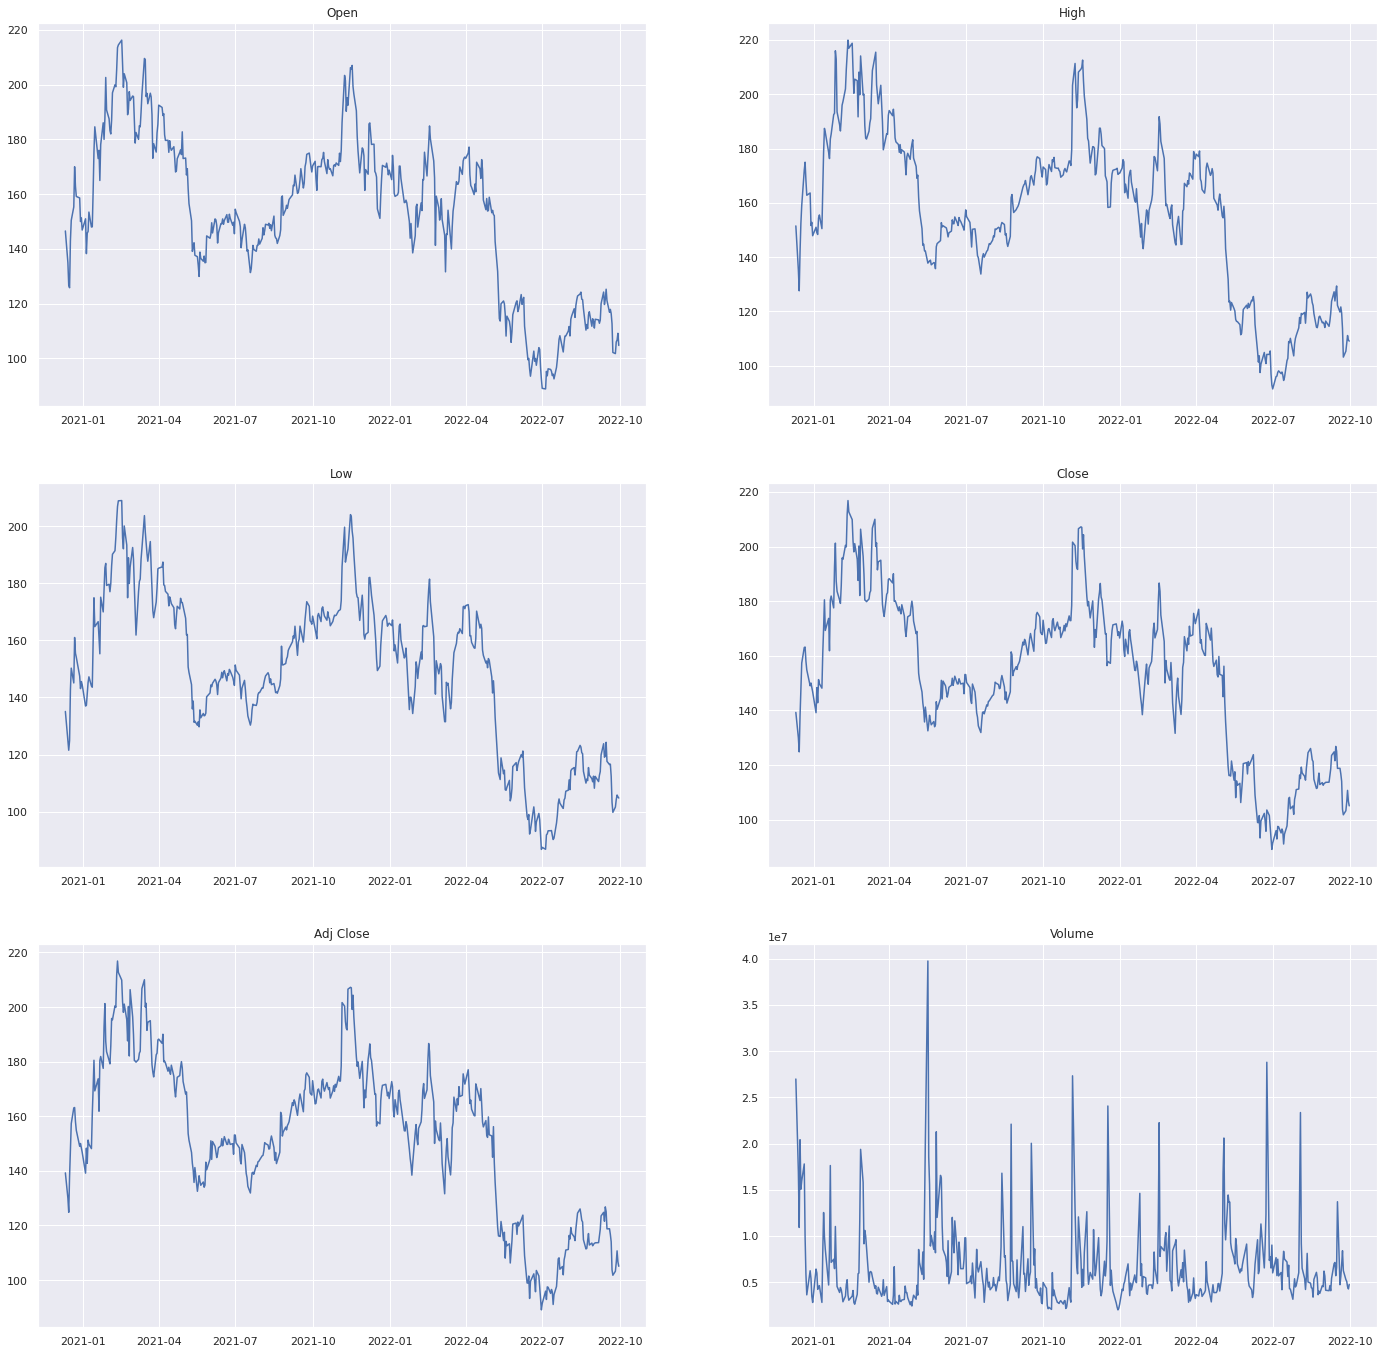

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt

columns = list(dataframe.columns)
del columns[0]
sns.set()
fig, axs = plt.subplots(3, 2, figsize=(24, 24))
for i in range(3):
  for j in range(2):
    axs[i, j].plot(dataframe['Date'], dataframe[columns[i*2+j]])
    axs[i, j].set_title(columns[i*2+j])
plt.show()

In [4]:
dataframe.corr()

,Open,High,Low,Close,Adj Close,Volume
Open,1.000000,0.992400,0.992226,0.983982,0.983982,-0.161547
High,0.992400,1.000000,0.990039,0.992992,0.992992,-0.118431
Low,0.992226,0.990039,1.000000,0.992306,0.992306,-0.186775
Close,0.983982,0.992992,0.992306,1.000000,1.000000,-0.137389
Adj Close,0.983982,0.992992,0.992306,1.000000,1.000000,-0.137389
Volume,-0.161547,-0.118431,-0.186775,-0.137389,-0.137389,1.000000


In [6]:
look_back = 34
sample_size = len(dataframe) - look_back
past_size = int(sample_size*0.8)
future_size = sample_size - past_size +1

In [7]:
import numpy as np

def make_dataset(raw_data, look_back=34):
  _X = []
  _y = []
  
  for i in range(len(raw_data) - look_back):
    _X.append(raw_data[i : i + look_back])
    _y.append(raw_data[i + look_back])
  
  _X = np.array(_X).reshape(len(_X), look_back, 1)
  _y = np.array(_y).reshape(len(_y), 1)
  
  return _X, _y

In [19]:
from sklearn import preprocessing

Xs = []
for i in range(len(columns)):
  Xs.append(preprocessing.minmax_scale(dataframe[columns[i]]))
Xs = np.array(Xs)

X_all = []
y_all = []
for i in range(len(columns)):
  X_now, y_now = make_dataset(Xs[i], look_back=look_back)
  X_all.append(X_now)
  y_all.append(y_now)

X_con = np.concatenate(X_all, axis=2)
X = X_con
y = y_all[len(y_all)-1]

In [24]:
X_past = X[:past_size]
X_future = X[past_size-1:]
y_past = y[:past_size]
y_future = y[past_size-1:]

X_train = X_past
y_train = y_past
X_test = X_future
y_test = y_future

In [10]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 135 kB 25.3 MB/s 
     |████████████████████████████████| 1.6 MB 55.3 MB/s 


In [25]:
from keras.layers import InputLayer, LSTM, Dense, BatchNormalization, Bidirectional, Dropout
from keras.optimizers import SGD, Adam
from keras.losses import Huber
from keras.models import Sequential

def model_builder(hp):
  lstm_unit = hp.Int('lstm_2', 16, 128, 16)
  dense_unit = hp.Int('lstm_2', 8, 32, 4)
  model = Sequential([
      InputLayer(input_shape=(np.array(X_train).shape[1], np.array(X_train).shape[2]), name="input_layer"),
      Bidirectional(LSTM(lstm_unit, return_sequences=True), name="birectional_lstm_1"),
      BatchNormalization(name="batch_normalization_1"),
      Bidirectional(LSTM(lstm_unit), name="birectional_lstm_2"),
      BatchNormalization(name="batch_normalization_2"),
      Dropout(0.2, name="dropout"),
      Dense(dense_unit, activation="relu", name="dense_1"),
      Dense(1, name="dense_2"),
  ])
  
  learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])
  optimizer = Adam(learning_rate=learning_rate) if hp.Choice('optimizer', ['adam', 'sgd']) == 'adam' else SGD(learning_rate=learning_rate)

  model.compile(loss=Huber(),
                optimizer=optimizer,
                metrics=["mae"])
  return model

In [26]:
import keras_tuner as kt

tuner = kt.Hyperband(hypermodel = model_builder,
                             objective = 'mae',
                             max_epochs = 10,
                             factor = 3,
                             directory = folder_path + 'results_dir',
                             project_name = 'airbnb')
tuner.search_space_summary()

Search space summary
Default search space size: 3
lstm_2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam', 'sgd'], 'ordered': False}


In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

best_weight = ModelCheckpoint(folder_path + "tuner{epoch:02d}-{mae:.4f}.h5",
                              monitor="mae",
                              mode="min",
                              save_best_only=True,
                              verbose=1)
stop_early = EarlyStopping(monitor='mae', patience=5)

tuner.search(X_train, y_train, epochs=5,
             callbacks=[stop_early, best_weight],
             validation_data=(X_test, y_test),
             verbose=2)

Trial 30 Complete [00h 00m 13s]
mae: 0.3947252631187439

Best mae So Far: 0.07182828336954117
Total elapsed time: 00h 05m 21s


In [28]:
from keras.models import load_model

model = load_model(folder_path + 'tuner09-0.0770.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 birectional_lstm_1 (Bidirec  (None, 34, 64)           9984      
 tional)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 34, 64)           256       
 hNormalization)                                                 
                                                                 
 birectional_lstm_2 (Bidirec  (None, 64)               24832     
 tional)                                                         
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 64)                0

In [29]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.4,   
                              patience=2, 
                              min_lr=0.001,
                              verbose=1
                              )
best_weight = ModelCheckpoint(folder_path + "{epoch:02d}-{val_loss:.4f}.h5",
                              monitor="val_loss",
                              mode="min",
                              save_best_only=True,
                              verbose=1)
stop_early = EarlyStopping(monitor='val_loss', patience=3)
callbacks = [stop_early, best_weight, reduce_lr]

history = model.fit(X_train, y_train,
                    epochs=200,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/200
 9/11 [=======================>......] - ETA: 0s - loss: 0.0055 - mae: 0.0708
Epoch 1: val_loss improved from inf to 0.00496, saving model to /content/drive/MyDrive/Learning Journey/AirBnB/01-0.0050.h5
11/11 [==============================] - 6s 244ms/step - loss: 0.0066 - mae: 0.0744 - val_loss: 0.0050 - val_mae: 0.0585 - lr: 0.1000
Epoch 2/200
 9/11 [=======================>......] - ETA: 0s - loss: 0.0061 - mae: 0.0808
Epoch 2: val_loss did not improve from 0.00496
11/11 [==============================] - 0s 17ms/step - loss: 0.0068 - mae: 0.0811 - val_loss: 0.0050 - val_mae: 0.0546 - lr: 0.1000
Epoch 3/200
 9/11 [=======================>......] - ETA: 0s - loss: 0.0068 - mae: 0.0708
Epoch 3: val_loss did not improve from 0.00496

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.04000000059604645.
11/11 [==============================] - 0s 18ms/step - loss: 0.0066 - mae: 0.0715 - val_loss: 0.0050 - val_mae: 0.0596 - lr: 0.1000
Epoch 4/200
 9/11 [==================

In [30]:
import matplotlib.pyplot as plt

def graph_history(title, subtitle, interval):
    plt.plot(history.history[title], label = title)
    plt.plot(history.history[subtitle], label = subtitle)
    plt.xlabel('Epoch')
    plt.ylabel(title)
    plt.ylim(interval)
    plt.legend(loc='lower right')

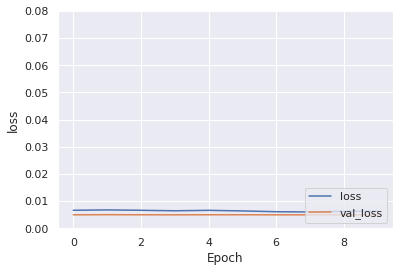

In [33]:
graph_history('loss', 'val_loss', [0.0, 0.08])

Nama : Oktavia Citra Resmi Rachmawati
Email : oktaviacitraaa@gmail.com